In [1]:
import itk
from itk import TubeTK as ttk

import numpy as np
import struct
import matplotlib.pyplot as plt

from itkwidgets import view

In [2]:
with open('../bmenv2.dat', mode='rb') as file:
    fileContent = file.read()

In [3]:
dt = np.dtype(np.float64)
dt = dt.newbyteorder('<')
data_1d = np.frombuffer(fileContent, dtype=dt)

In [4]:
nlateral = 92
nframes = 200  #200
ndepth = 153
nelevation = 102

In [5]:
data_raw = np.reshape(data_1d, [nlateral,nframes,ndepth,nelevation], order='C')

In [6]:
data = np.transpose(data_raw, (1,3,0,2))

In [74]:
fixed_id = 0
moving_id = 10

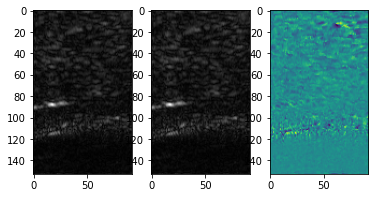

In [75]:
plt.subplot(1,3,1)
plt.imshow(np.rot90(data[fixed_id,100,:,:]),"gray")
plt.subplot(1,3,2)
plt.imshow(np.rot90(data[moving_id,100,:,:]),"gray")
plt.subplot(1,3,3)
plt.imshow(np.rot90(data[fixed_id,100,:,:]-data[moving_id,100,:,:]))

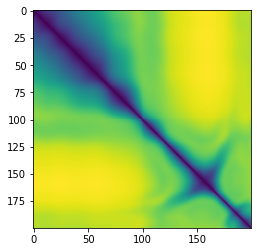

In [80]:
diff = np.empty([data.shape[0],data.shape[0]])
for i in range(data.shape[0]):
    for j in range(data.shape[0]):
        diff[i,j] = np.sum(np.abs(data[i,:,:,:]-data[j,:,:,:]))
plt.imshow(diff)

41 175


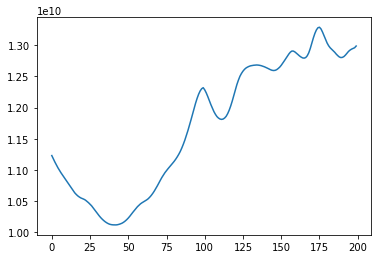

In [97]:
diff_avg = np.average(diff,axis=0)
plt.plot(diff_avg)
fixed_id = np.argmin(diff_avg)
moving_id = np.argmax(diff_avg)
print( fixed_id, moving_id )

In [200]:
tmp_fixed = np.average(data[fixed_id-2:fixed_id+2],axis=0)
tmp_moving = np.average(data[moving_id-2:moving_id+2],axis=0)

img_fixed = itk.GetImageViewFromArray(tmp_fixed.astype(np.float32))
img_fixed_blur = itk.RecursiveGaussianImageFilter(img_fixed,sigma=5)
tmp_fixed_blur = itk.GetArrayViewFromImage(img_fixed_blur)

img_moving = itk.GetImageViewFromArray(tmp_moving.astype(np.float32))
img_moving_blur = itk.RecursiveGaussianImageFilter(img_moving,sigma=5)
tmp_moving_blur = itk.GetArrayViewFromImage(img_moving_blur)

tmp_diff = tmp_fixed_blur - tmp_moving_blur
tmp_diff = np.where(tmp_moving_blur>0,tmp_diff,0)

<Figure size 432x288 with 0 Axes>

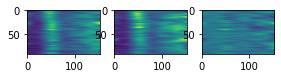

<Figure size 432x288 with 0 Axes>

In [201]:
plt.subplot(1,4,1)
plt.imshow(tmp_fixed_blur[10,:,:])
plt.subplot(1,4,2)
plt.imshow(tmp_moving_blur[10,:,:])
plt.subplot(1,4,3)
plt.imshow(tmp_diff[10,:,:])
plt.figure()


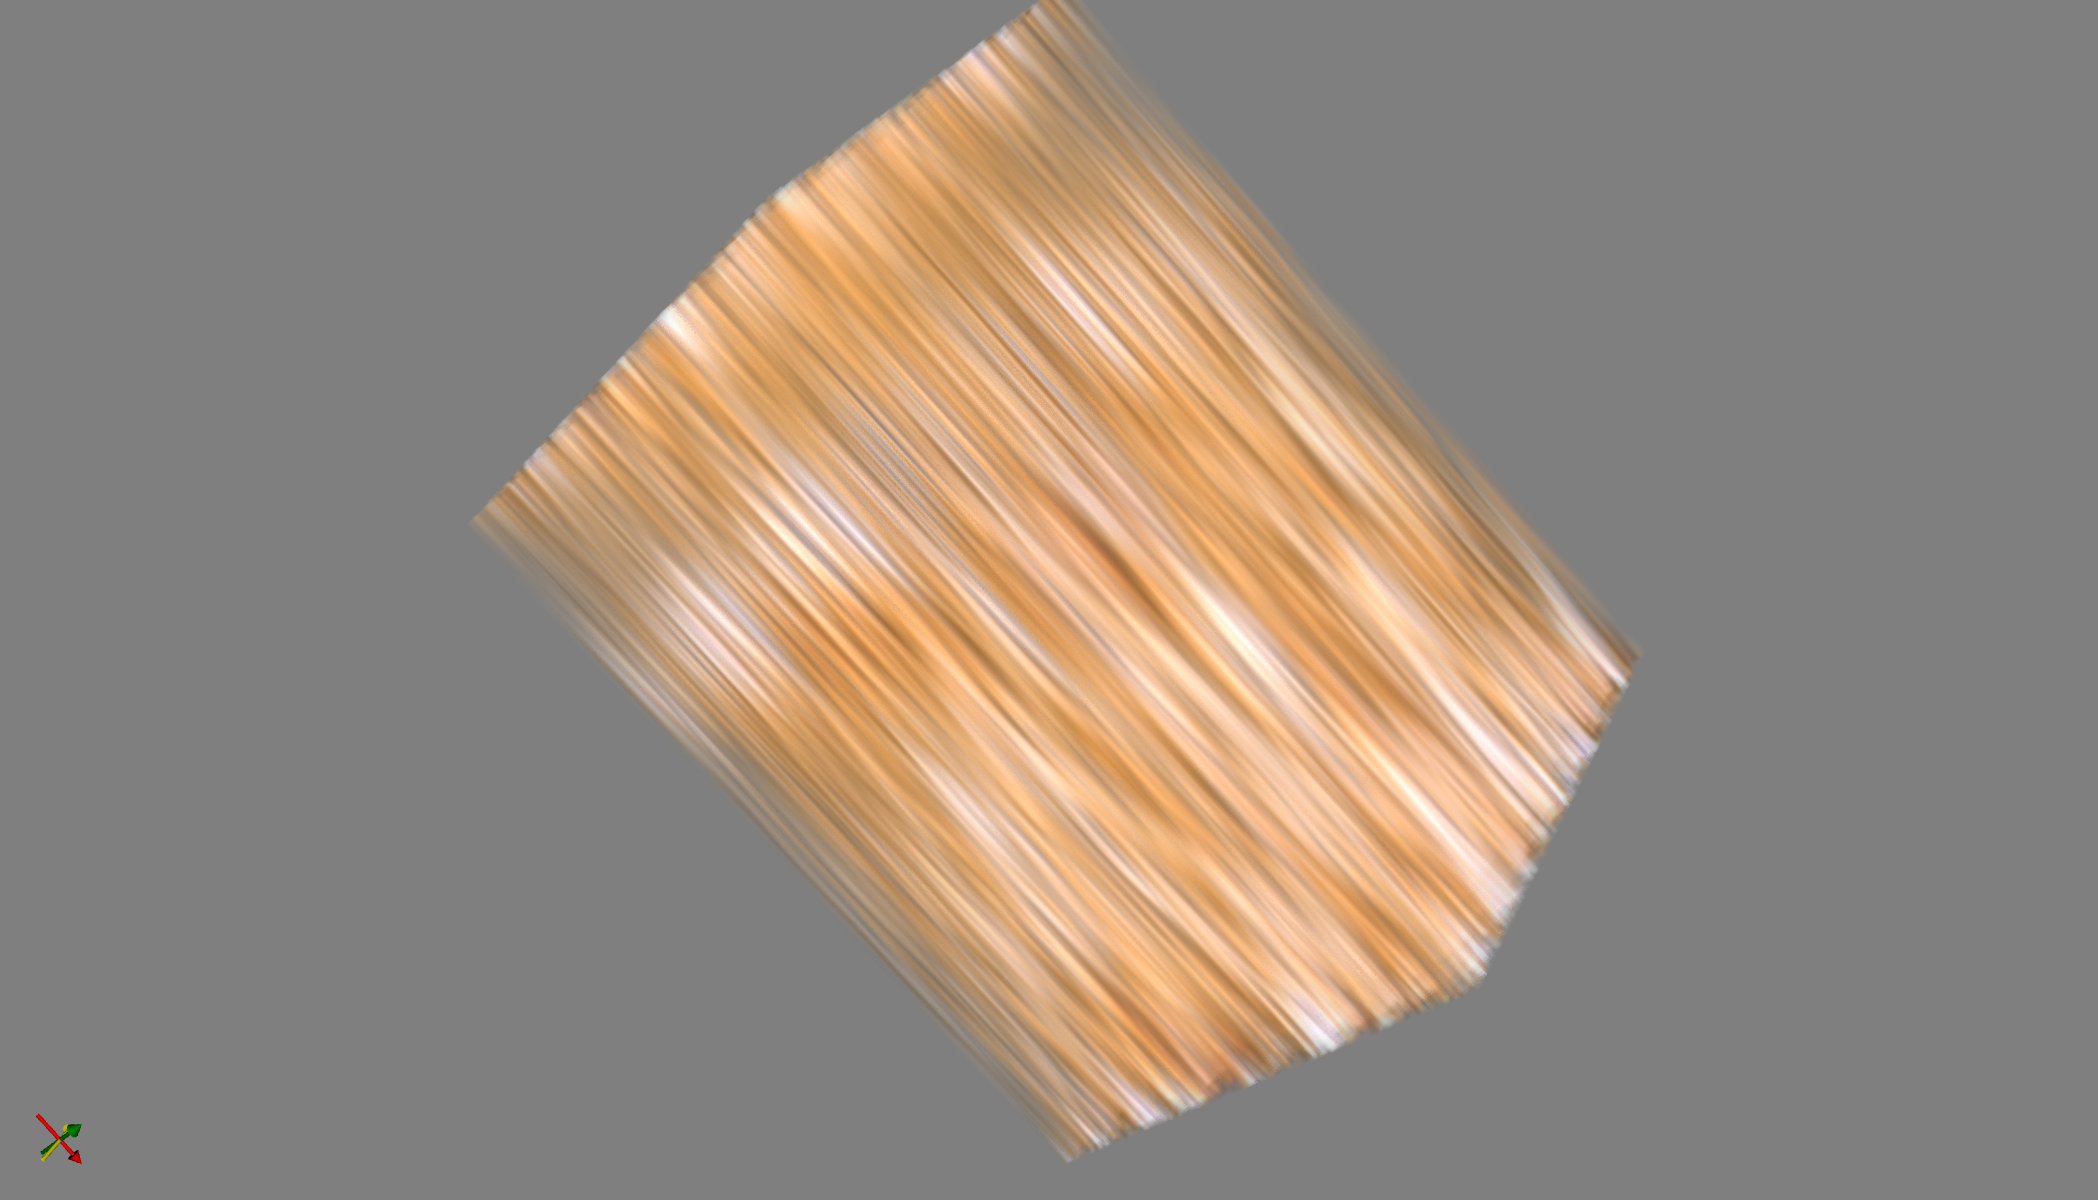
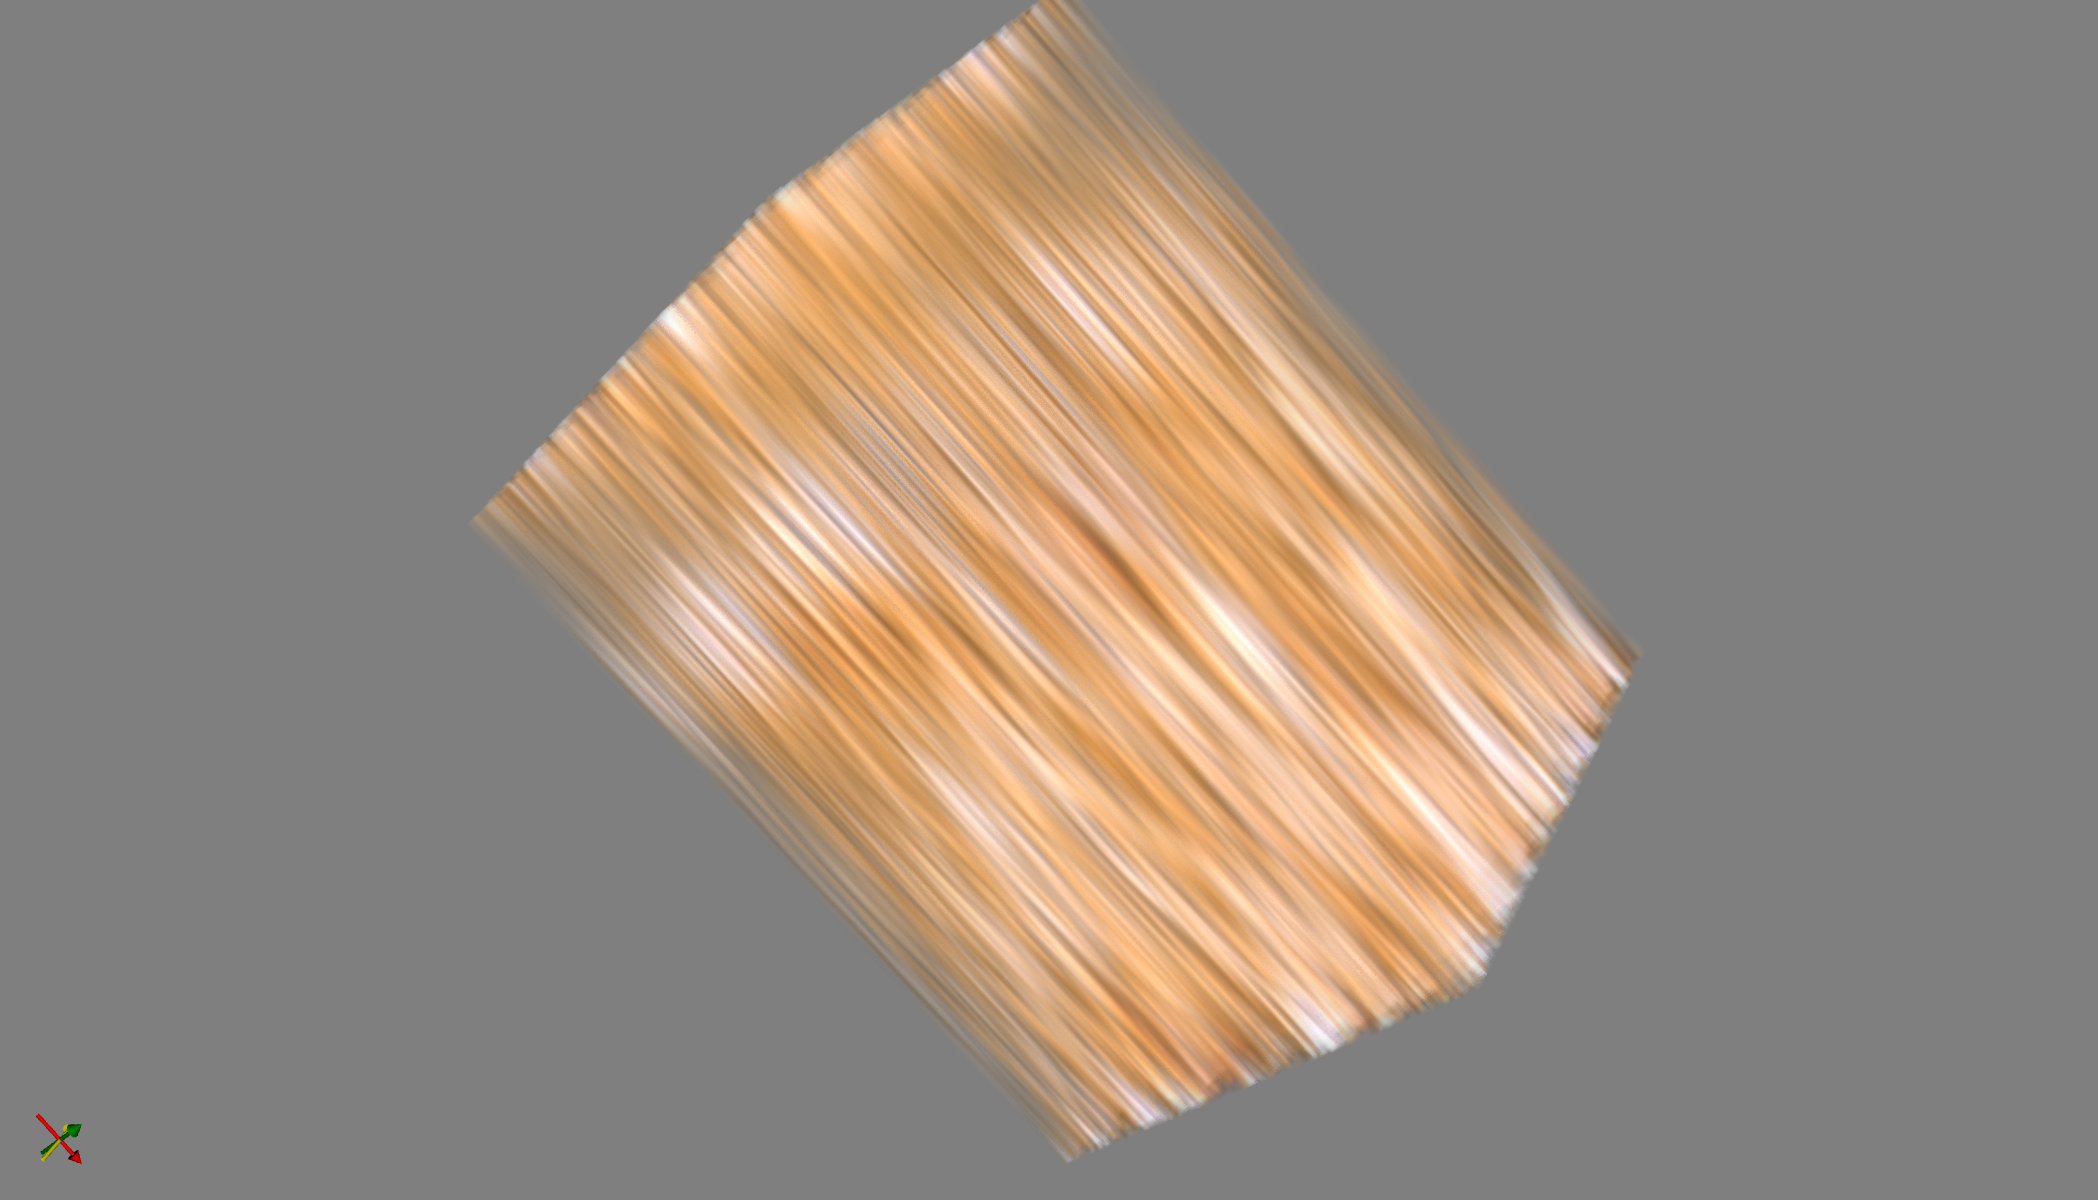

<IPython.core.display.Javascript object>

In [209]:
view(tmp_diff)

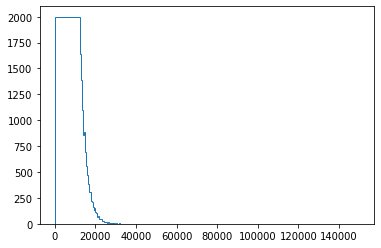

In [202]:
tmp_counts, tmp_bins = np.histogram(np.abs(tmp_diff.flatten()),bins=500,range=(0,150000))
tmp_counts = np.where(tmp_counts>2000,2000, tmp_counts)
plt.stairs(tmp_counts, tmp_bins)

In [203]:
Reg = ttk.RegisterImages[itk.Image[itk.F,3]].New()
Reg.SetFixedImage(img_fixed_blur)
Reg.SetMovingImage(img_moving_blur)
Reg.SetReportProgress(True)
Reg.SetRegistration("PIPELINE_AFFINE")
#Reg.SetMetric("MATTES_MI_METRIC")
Reg.SetMetric("MEAN_SQUARED_ERROR_METRIC")

Reg.SetExpectedOffsetMagnitude(10)
Reg.SetExpectedRotationMagnitude(0.001)
Reg.SetRigidSamplingRatio(0.1)
Reg.SetRigidMaxIterations(1000)

Reg.SetExpectedScaleMagnitude(0.01)
Reg.SetExpectedSkewMagnitude(0.001)
Reg.SetAffineSamplingRatio(0.1)
Reg.SetAffineMaxIterations(1000)
#Reg.SetUseEvolutionaryOptimization(False)
Reg.Update()

In [204]:
img_moving_reg = Reg.GetFinalMovingImage()

In [205]:
data_moving_reg = itk.GetArrayFromImage(img_moving_reg)

In [206]:
reg_diff = tmp_fixed_blur - data_moving_reg
reg_diff = np.where(data_moving_reg>0,reg_diff,0)


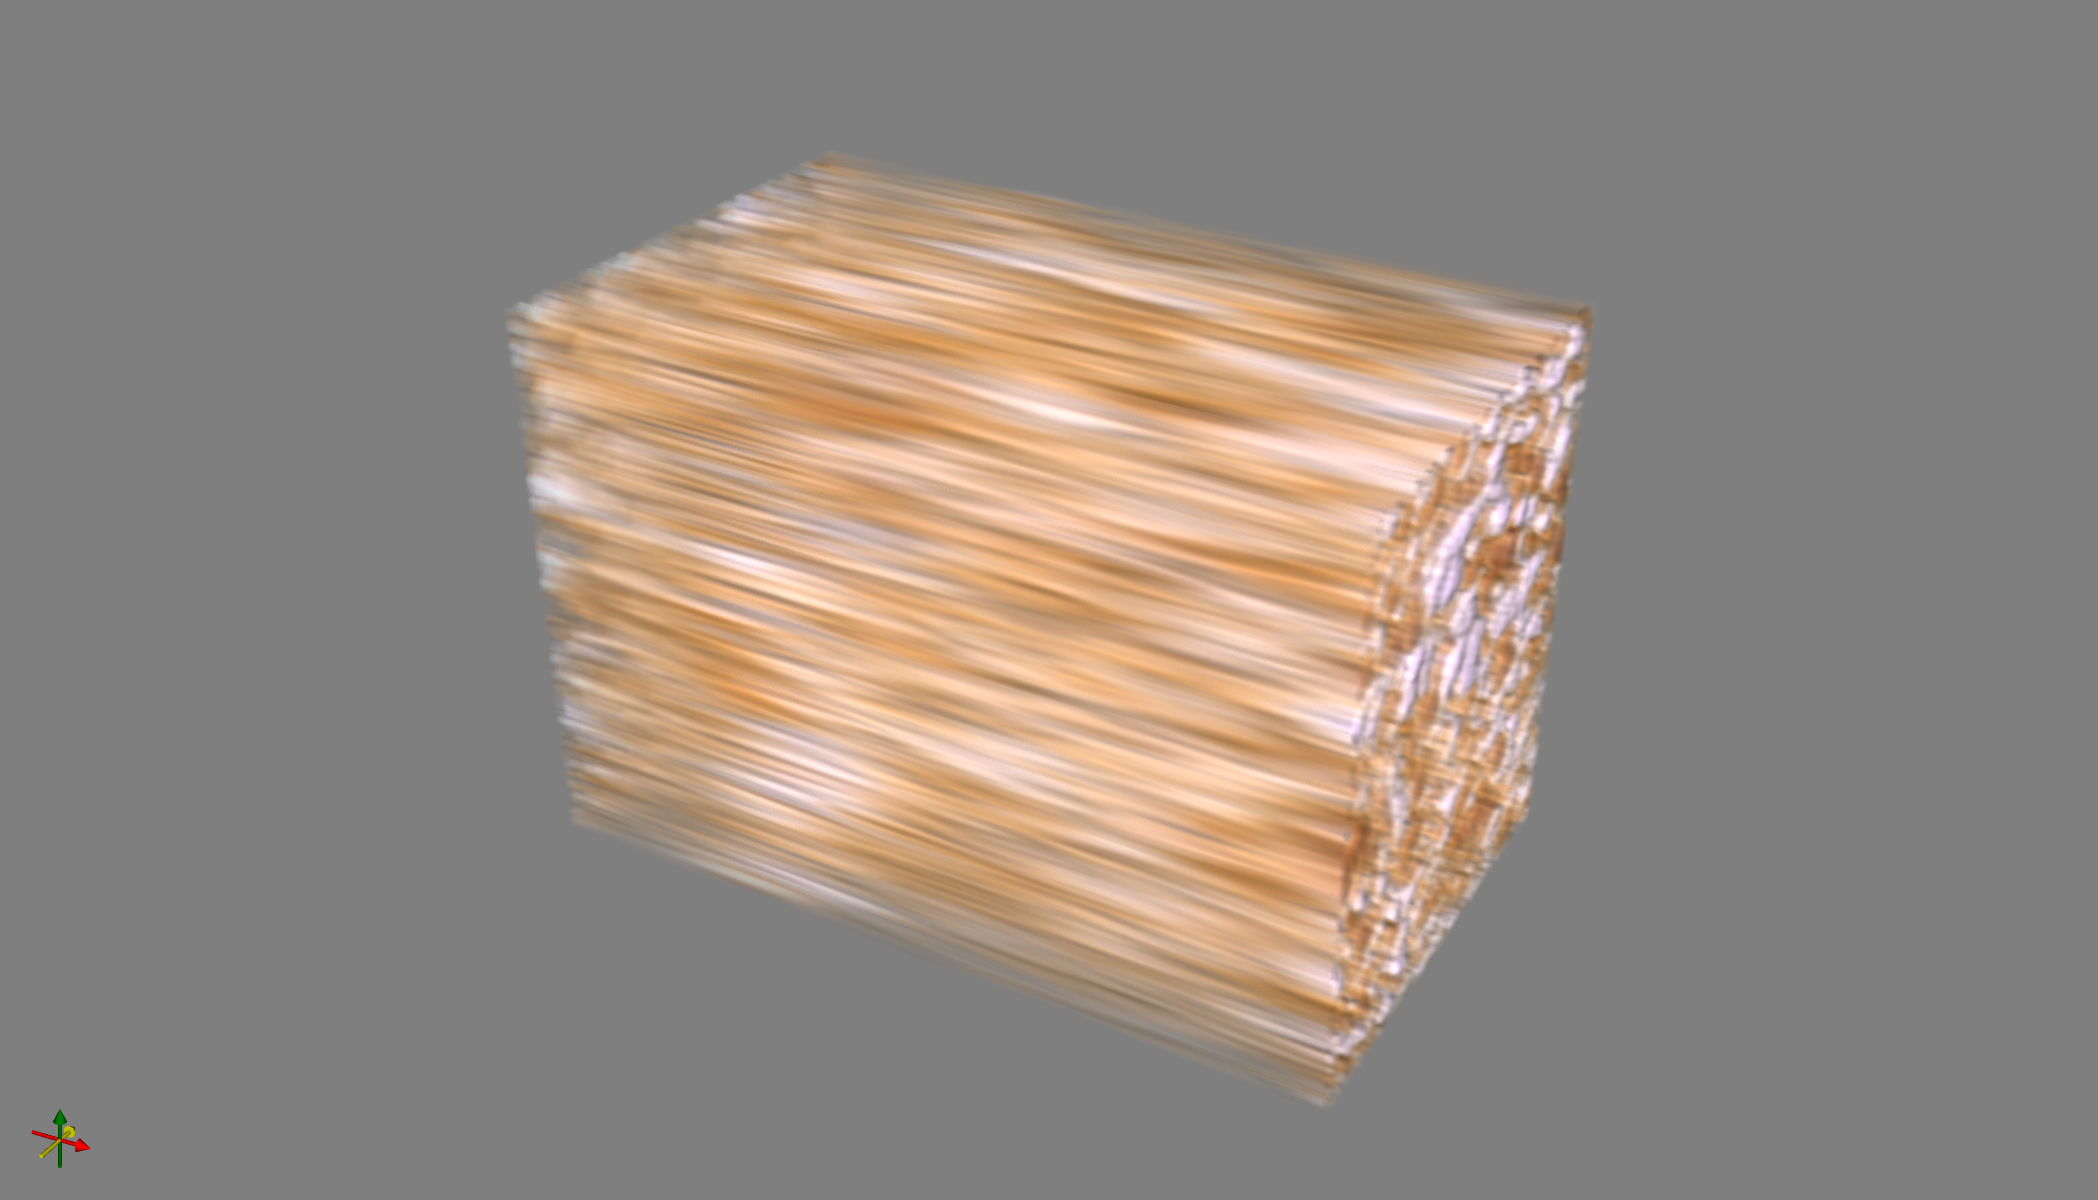
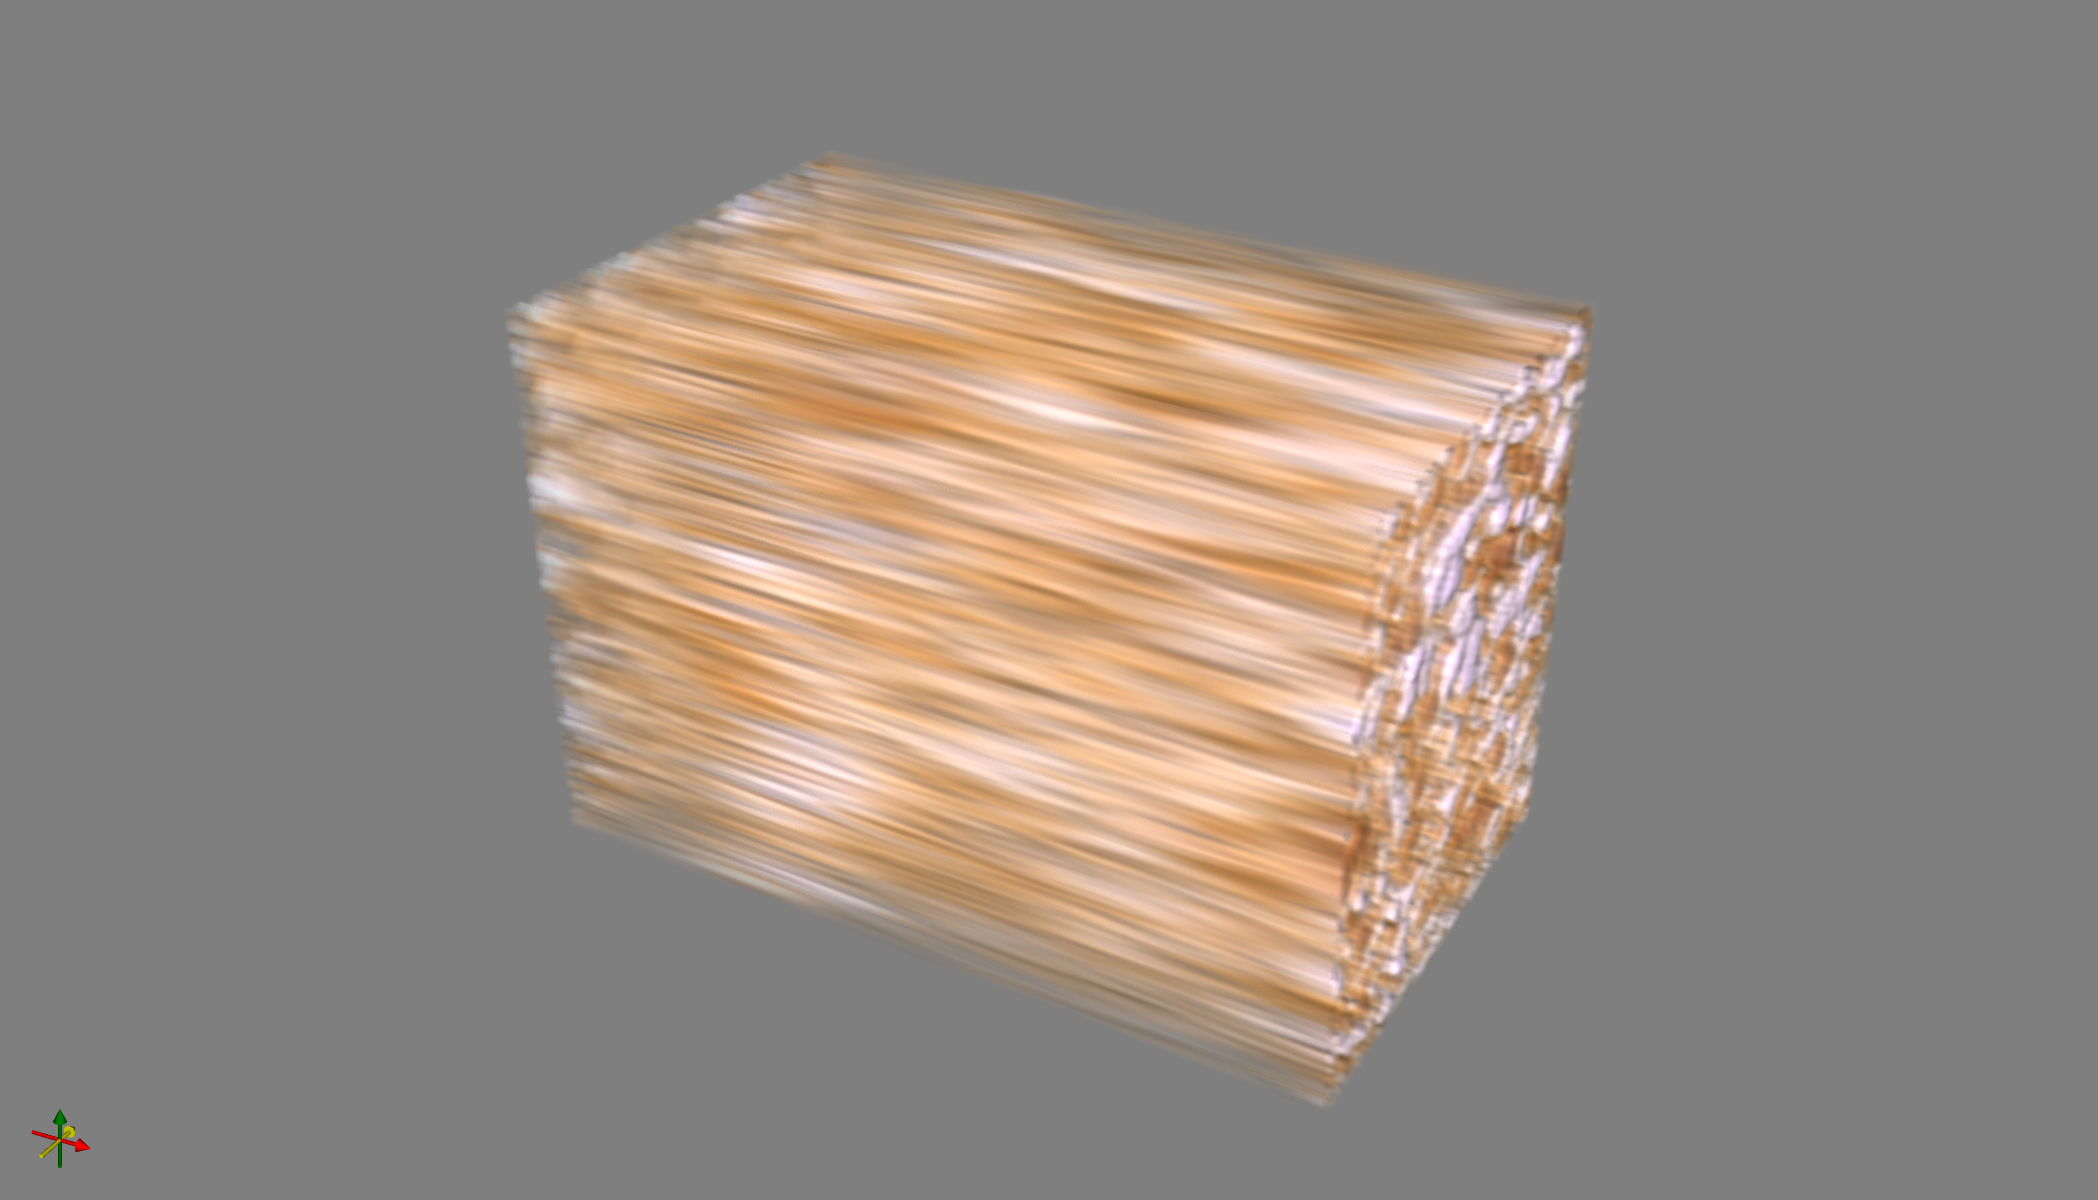

<IPython.core.display.Javascript object>

In [207]:
view(reg_diff)

(<matplotlib.patches.StepPatch at 0x252d0c807f0>,
 <matplotlib.patches.StepPatch at 0x252d0c80a00>)

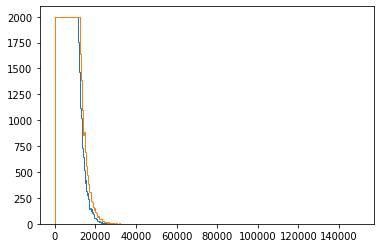

In [208]:
reg_counts, reg_bins = np.histogram(np.abs(reg_diff.flatten()),bins=500,range=(0,150000))
reg_counts = np.where(reg_counts>2000,2000, reg_counts)
plt.stairs(reg_counts, reg_bins), plt.stairs(tmp_counts, tmp_bins)